# Atividade 2

Implementar, para a equação da difusão, os seguintes métodos:

- FTBS
- Du Fort-Frankel
- Crank-Nicolsin

Analisar consistênsia, convergência, estabilidade

## Equação da difusão

$$
u_t = k u_{xx}
$$

Solução (transformada de Fourier):

$$
\mathscr{F}(u_t) = \hat u_t \\
\mathscr{F}(u_{xx}) = (-\omega^2) \hat u (t,\omega) \\
\hat u_t = -\omega ^2\hat u \\
\hat u(t, \omega) = \hat u_0(\omega) e^{-bw^2t}
$$


## Implementação dos métodos e propriedades

### Condições iniciais e de fronteira

Os três métodos mencionados no enunciado foram implementados com condições as condições de fronteira periódicas, de Dirichlet, e de Neumann. No caso das condições de Dirichlet e Neumann, foram escolhidas funções para as condições de fronteira tais que a solução do problema para condição inicial $u(0,x)= \cos(2  \pi  x_m)$ seja

$$
u(t,x)= \cos(2  \pi  x_m)  e^{-4  \pi^2  k  t}
$$

Ou seja, para condições de fronteira de Dirichlet, as funções $f_0$ na borda esquerda do domínio e $f_1$ na borda direita do domínio são

$$
f_0(t) =  u(t,0) = \cos(2  \pi  0)  e^{-4  \pi^2  k  t} =  e^{-4  \pi^2  k  t} \\
f_1(t) =  u(t,1) = \cos(2  \pi  1)  e^{-4  \pi^2  k  t} =  e^{-4  \pi^2  k  t}
$$

E no caso das condições de fronteira de Neumann, foi escolhido Neumann nulo, que já é satisfeita pela solução acima.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from typing import Callable

import pandas as pd
import imageio


# Analytical solutions
def exact_u_erf(t, x):
    return erf((1 - x) / np.sqrt(4 * t)) / 2 + erf((1 + x) / np.sqrt(4 * t)) / 2


def exact_u_sin(t, x, k):
    return np.sin(2 * np.pi * x) * np.exp(-4 * np.pi**2 * k * t)


def exact_u_cos(t, x, k):
    return np.cos(2 * np.pi * x) * np.exp(-4 * np.pi**2 * k * t)


# Linear systems solvers
def solve_tridiagonal(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray):
    a = np.copy(a)
    a = a.astype(np.float64)
    b = np.copy(b)
    b = b.astype(np.float64)
    c = np.copy(c)
    c = c.astype(np.float64)
    d = np.copy(d)
    d = d.astype(np.float64)

    n = len(b)
    # Eliminate "a_i"s
    for j in range(1, n):
        b[j] = b[j] - a[j - 1] / b[j - 1] * c[j - 1]
        d[j] = d[j] - a[j - 1] / b[j - 1] * d[j - 1]

    # Produce solution
    # Initialize solution
    w = np.empty(n)
    w[n - 1] = d[n - 1] / b[n - 1]
    for j in range(n - 2, -1, -1):
        w[j] = (d[j] - c[j] * w[j + 1]) / b[j]

    return w


def solve_cyclic_tridiagonal(
    diag_a: np.ndarray,
    diag_b: np.ndarray,
    diag_c: np.ndarray,
    A: np.ndarray,
    B: np.ndarray,
    b: float,
    D: np.ndarray,
    d: float,
):
    """Solve cyclic tridiagonal linear system

    :param diag_a: Lower diagonal from the tridiagonal portion of system (vector)
    :type diag_a: np.ndarray
    :param diag_b: Diagonal from the tridiagonal portion of system (vector)
    :type diag_b: np.ndarray
    :param diag_c: Upper diagonal from the tridiagonal portion of system (vector)
    :type diag_c: np.ndarray
    :param B: Last column of system containing boundary condition information (vector)
    :type B: np.ndarray
    :param A: Last row of system containing boundary condition information (vector)
    :type A: np.ndarray
    :param b: Last element of system (scalar)
    :type b: float
    :param D: Upper portion of independent terms (vector)
    :type D: np.ndarray
    :param d: Last independent term (scalar)
    :type d: np.ndarray
    """

    # Calculate solutions to partial linear systems
    u = solve_tridiagonal(diag_a, diag_b, diag_c, D)
    v = solve_tridiagonal(diag_a, diag_b, diag_c, B)

    # Calculate last independent term bottom_w
    bottom_w = (d - np.dot(A, u)) / (b - np.dot(A, v))

    # Calculate the remaining independent terms top_ws
    top_ws = np.array(u - bottom_w * v)

    return np.append(top_ws, bottom_w)


# Helper functions
def L2_norm(v: np.ndarray, delta_x: float):
    """Calculate L2 (h) norm of vector v

    :param v: vector to calculate the norm of
    :type v: np.ndarray
    :param delta_x: distance between each point of vector
    :type delta_x: float
    :return: norm
    :rtype: float
    """
    return np.sqrt(delta_x * np.sum(v**2))


def initialize_solution(N, M, u0):
    # Initialize solution
    u = np.zeros((N + 1, M + 1))
    # Assign u0 to u(0, x)
    u[0, :] = u0
    return u


def calculate_parameters(t_0, T, N, x_0, x_M, M):
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2
    return delta_t, delta_x, mu


def create_table(list_of_arrays, column_names):
    df = pd.DataFrame(
        np.round(
            np.array(list_of_arrays).T,
            decimals=10,
        ),
        columns=column_names,
    )
    return df


def create_ratio_column(
    df, ratio_column_name="Error ratio", raw_column_name="Error [L2 norm]"
):
    df[ratio_column_name] = df[raw_column_name] / df[raw_column_name].shift(1)
    df[ratio_column_name] = df[ratio_column_name].fillna("")

    return df


# Finite difference solvers
def diffusion_step_crank_nicolson_periodic(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Update function between boundary points
    diag_a = [-k * mu / 2] * (M - 2)
    diag_b = [1 + k * mu] * (M - 1)
    diag_c = [-k * mu / 2] * (M - 2)

    D = np.zeros(M - 1)
    D[1 : M - 1] = u[n, 1 : M - 1] + k * mu / 2 * (
        u[n, 0 : M - 2] - 2 * u[n, 1 : M - 1] + u[n, 2:M]
    )
    D[0] = u[n, 0] + k * mu / 2 * (u[n, M - 1] - 2 * u[n, 0] + u[n, 1])
    d = u[n, M - 1] + k * mu / 2 * (u[n, M - 2] - 2 * u[n, M - 1] + u[n, 0])

    A = np.zeros(M - 1)
    A[0] = diag_a[0]
    A[-1] = diag_a[0]
    B = np.copy(A)
    b = diag_b[0]

    u[n + 1, 0:M] = solve_cyclic_tridiagonal(
        diag_a,
        diag_b,
        diag_c,
        A,
        B,
        b,
        D,
        d,
    )

    u[n + 1, M] = u[n + 1, 0]

    return u[n + 1, :]


def diffusion_step_crank_nicolson_dirichlet(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Dirichlet - analytical solution at edge points
    def f0(t: float):
        return exact_u_cos(t, x_0, k)

    def f1(t: float):
        return exact_u_cos(t, x_M, k)

    # Boundary conditions
    u[n + 1, 0] = f0((n + 1) * delta_t)
    u[n + 1, M] = f1((n + 1) * delta_t)

    # Update function between boundary points
    diag_a = [-k * mu / 2] * (M - 2)
    diag_b = [1 + k * mu] * (M - 1)
    diag_c = [-k * mu / 2] * (M - 2)

    d = np.zeros(M - 1)
    d = u[n, 1:M] + k * mu / 2 * (u[n, 2 : M + 1] - 2 * u[n, 1:M] + u[n, 0 : M - 1])
    d[0] += k * mu / 2 * u[n + 1, 0]
    d[-1] += k * mu / 2 * u[n + 1, M]

    u[n + 1, 1:M] = solve_tridiagonal(
        diag_a,
        diag_b,
        diag_c,
        d,
    )

    return u[n + 1, :]


def diffusion_step_crank_nicolson_neumann(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Update function between boundary points
    diag_a = [-k * mu / 2] * (M - 2)
    diag_b = [1 + k * mu] * (M - 1)
    diag_c = [-k * mu / 2] * (M - 2)

    d = np.zeros(M - 1)
    d = u[n, 1:M] + k * mu / 2 * (u[n, 2 : M + 1] - 2 * u[n, 1:M] + u[n, 0 : M - 1])
    d[0] += (k * mu / 2) * (4 * u[n, 1] - u[n, 2]) / 3
    d[-1] += (k * mu / 2) * (4 * u[n, M - 1] - u[n, M - 2]) / 3

    u[n + 1, 1:M] = solve_tridiagonal(
        diag_a,
        diag_b,
        diag_c,
        d,
    )

    # Boundary conditions
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2]) / 3
    u[n + 1, M] = (4 * u[n + 1, M - 1] - u[n + 1, M - 2]) / 3

    return u[n + 1, :]


def diffusion_step_ftcs_periodic(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    """Calculate u^{n+1}_m for m \in [0, M] (includes boundary conditions)

    :param u: function
    :type u: np.ndarray
    :param n: current time step
    :type n: int
    :param t_0: _description_
    :type t_0: float
    :param T: _description_
    :type T: float
    :param N: _description_
    :type N: int
    :param x_0: _description_
    :type x_0: float
    :param x_M: _description_
    :type x_M: float
    :param M: _description_
    :type M: int
    :param k: _description_
    :type k: float
    """
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Boundary conditions
    u[n + 1, 0] = (1 - 2 * k * mu) * u[n, 0] + k * mu * (u[n, M - 1] + u[n, 1])
    u[n + 1, M] = u[n + 1, 0]
    # Update function between boundary points
    u[n + 1, 1:M] = (1 - 2 * k * mu) * u[n, 1:M] + k * mu * (
        u[n, 2 : M + 1] + u[n, 0 : M - 1]
    )

    return u[n + 1, :]


def diffusion_step_ftcs_dirichlet(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    """Calculate u^{n+1}_m for m \in [0, M] (includes boundary conditions)

    :param u: function
    :type u: np.ndarray
    :param n: current time step
    :type n: int
    :param t_0: _description_
    :type t_0: float
    :param T: _description_
    :type T: float
    :param N: _description_
    :type N: int
    :param x_0: _description_
    :type x_0: float
    :param x_M: _description_
    :type x_M: float
    :param M: _description_
    :type M: int
    :param k: _description_
    :type k: float
    """
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Boundary conditions
    u[n + 1, 0] = exact_u_cos((n + 1) * delta_t, x_0, k)
    u[n + 1, -1] = exact_u_cos((n + 1) * delta_t, x_M, k)
    # Update function between boundary points
    u[n + 1, 1:M] = (1 - 2 * k * mu) * u[n, 1:M] + k * mu * (
        u[n, 2 : M + 1] + u[n, 0 : M - 1]
    )

    return u[n + 1, :]


def diffusion_step_ftcs_neumann(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    """Calculate u^{n+1}_m for m \in [0, M] (includes boundary conditions)

    :param u: function
    :type u: np.ndarray
    :param n: current time step
    :type n: int
    :param t_0: _description_
    :type t_0: float
    :param T: _description_
    :type T: float
    :param N: _description_
    :type N: int
    :param x_0: _description_
    :type x_0: float
    :param x_M: _description_
    :type x_M: float
    :param M: _description_
    :type M: int
    :param k: _description_
    :type k: float
    """
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Update function between boundary points
    u[n + 1, 1:M] = (1 - 2 * k * mu) * u[n, 1:M] + k * mu * (
        u[n, 2 : M + 1] + u[n, 0 : M - 1]
    )
    # Boundary conditions
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2]) / 3
    u[n + 1, M] = (4 * u[n + 1, M - 1] - u[n + 1, M - 2]) / 3

    return u[n + 1, :]


def diffusion_step_dufort_periodic(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    """Calculate u^{n+1}_m for m \in [0, M] (includes boundary conditions)

    :param u: function
    :type u: np.ndarray
    :param n: current time step
    :type n: int
    :param t_0: _description_
    :type t_0: float
    :param T: _description_
    :type T: float
    :param N: _description_
    :type N: int
    :param x_0: _description_
    :type x_0: float
    :param x_M: _description_
    :type x_M: float
    :param M: _description_
    :type M: int
    :param k: _description_
    :type k: float
    """
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    if n == 0:
        print("oioioioi")

    # Boundary Conditions
    u[n + 1, 0] = (
        (2 * k * mu) * (u[n, 1] + u[n, M - 1]) + (1 - 2 * k * mu) * (u[n - 1, 0])
    ) / (1 + 2 * k * mu)
    u[n + 1, M] = u[n + 1, 0]
    # Update function between boundary points
    u[n + 1, 1:M] = (
        (2 * k * mu) * (u[n, 0 : M - 1] + u[n, 2 : M + 1])
        + (1 - 2 * k * mu) * (u[n - 1, 1:M])
    ) / (1 + 2 * k * mu)

    return u[n + 1, :]


def diffusion_step_dufort_dirichlet(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    """Calculate u^{n+1}_m for m \in [0, M] (includes boundary conditions)

    :param u: function
    :type u: np.ndarray
    :param n: current time step
    :type n: int
    :param t_0: _description_
    :type t_0: float
    :param T: _description_
    :type T: float
    :param N: _description_
    :type N: int
    :param x_0: _description_
    :type x_0: float
    :param x_M: _description_
    :type x_M: float
    :param M: _description_
    :type M: int
    :param k: _description_
    :type k: float
    """
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Boundary Conditions
    u[n + 1, 0] = exact_u_cos((n + 1) * delta_t, x_0, k)
    u[n + 1, -1] = exact_u_cos((n + 1) * delta_t, x_M, k)
    # Update function between boundary points
    u[n + 1, 1:M] = (
        (2 * k * mu) * (u[n, 0 : M - 1] + u[n, 2 : M + 1])
        + (1 - 2 * k * mu) * (u[n - 1, 1:M])
    ) / (1 + 2 * k * mu)

    return u[n + 1, :]


def diffusion_step_dufort_neumann(
    u: np.ndarray,
    n: int,
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
):
    """Calculate u^{n+1}_m for m \in [0, M] (includes boundary conditions)

    :param u: function
    :type u: np.ndarray
    :param n: current time step
    :type n: int
    :param t_0: _description_
    :type t_0: float
    :param T: _description_
    :type T: float
    :param N: _description_
    :type N: int
    :param x_0: _description_
    :type x_0: float
    :param x_M: _description_
    :type x_M: float
    :param M: _description_
    :type M: int
    :param k: _description_
    :type k: float
    """
    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    # Update function between boundary points
    u[n + 1, 1:M] = (
        (2 * k * mu) * (u[n, 0 : M - 1] + u[n, 2 : M + 1])
        + (1 - 2 * k * mu) * (u[n - 1, 1:M])
    ) / (1 + 2 * k * mu)
    # Boundary conditions
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2]) / 3
    u[n + 1, M] = (4 * u[n + 1, M - 1] - u[n + 1, M - 2]) / 3

    return u[n + 1, :]


def solve_diffusion(
    t_0: float,
    T: float,
    N: int,
    x_0: float,
    x_M: float,
    M: int,
    k: float,
    u0: np.ndarray,
    step: Callable,
    num_preprocess_steps: int,
    preprocess_step: Callable = None,
):
    """Solve diffusion equation u_t = k u_{xx}

    :param t_0: initial time
    :type t_0: float
    :param T: final time
    :type T: float
    :param N: number of gaps between discrete time domain points (number of points in discrete time domain is N+1)
    :type N: int
    :param x_0: left boundary of domain
    :type x_0: float
    :param x_M: right boundary of domain
    :type x_M: float
    :param M: number of gaps between discrete space domain points (number of points in discrete space domain is M+1)
    :type M: int
    :param k: diffusion coefficient
    :type k: float
    :param u0: initial condition
    :type u0: np.ndarray
    :param step: function for calculating u^{n+1}_m
    :type step: Callable
    :param num_preprocess_steps: number of times the preprocess_step function will be called
    :type num_preprocess_steps: int
    :param preprocess_step: function for calculating u^{n+1}_m. Called before step. Used for multi step methods. Defaults to None
    :type preprocess_step: Callable, optional
    :return: u
    :rtype: np.ndarray
    """

    # Initialize solution
    # Assign u0 to u(0, x)
    u = initialize_solution(N, M, u0)

    if num_preprocess_steps > 0:
        for n in range(num_preprocess_steps):
            u[n + 1, :] = preprocess_step(u, n, t_0, T, N, x_0, x_M, M, k)

    # Run time steps
    for n in range(num_preprocess_steps, N):
        u[n + 1, :] = step(u, n, t_0, T, N, x_0, x_M, M, k)

    return u


def plot_function_2d(u: np.ndarray, fig, ax):
    colorplot = ax.imshow(u, origin="lower")
    fig.colorbar(colorplot, ax=ax)
    ax.set_xlabel(r"$m$")
    ax.set_ylabel(r"$n$")
    ax.set_title(r"$u(t,x)$")


def animate_u(N, T, x, u, FPS, fname):
    # Save every 24*T (or FPS*T) th step to get 24 (or FPS) fps
    print_counter = 0
    for i in range(0, len(u), int(N / FPS / T)):
        if print_counter > len(u) / int(N / FPS / T) / 4 or i >= len(u) - int(
            N / FPS / T
        ):
            print(
                f"Saving fig {i:04} ... {min((i+int(N / FPS / T))/len(u)*100, 100):3.0f}%"
            )
            print_counter = 0
        print_counter += 1

        fig = plt.figure(figsize=(6, 6))
        plt.ylabel("u")
        plt.xlabel("x")
        plt.title(r"$u^n_m$")
        plt.ylim(
            np.min(u) - (np.max(u) - np.min(u)) * 0.2,
            np.max(u) + (np.max(u) - np.min(u)) * 0.2,
        )
        plt.plot(x, u[i, :], color="k", linewidth=0.5)
        # plt.plot(x, exact_u_cos(i * (T - t_0) / N, x, k), color="#a007", linewidth=0.3)
        plt.savefig(f"/tmp/tmp-plot-{i:04}.png")
        plt.close()

    frames = []
    for i in range(0, len(u), int(N / FPS / T)):
        image = imageio.v2.imread(f"/tmp/tmp-plot-{i:04}.png")
        frames.append(image)
    imageio.mimsave(
        f"./{fname}.gif",  # output gif
        frames,  # array of input frames
        fps=24,  # optional: frames per second
        loop=0,  # optional: loops on the final gif
    )

### Exemplos com pulso retangular

Para poder visualizar melhor o efeito de cada condição de fronteira, foram feitos os experimentos abaixo com uma condição inicial de pulso retangular unitário com bordas em $\frac{1}{4}$ e $\frac{3}{4}$, para ser possível observar melhor as condições de Dirichlet e Neumann nulo.

Nesses exemplos, também foi adicionado um ruído à condição inicial. Como o ruído tem média nula e a solução da EDP é normalizadora, pode-se observar que a adição do ruído não altera significativamente a solução final.


#### Ex. 1 - Condição de fronteira de Dirichlet


In [2]:
# Domain parameters
t_0 = 0
T = 1
N = 400
x_0 = 0
x_M = 1
M = 400

# Diffusion coefficient
k = 0.3

# Initial condition
# Create x axis
x = np.linspace(x_0, x_M, M + 1)
# Create u0
u0 = np.zeros(M + 1)
u0[(x > 0.25) & (x < 0.75)] = 1

# Add noise to initial condition
scale = 0.05
average = 0
epsilon = np.random.normal(average, scale, len(u0))
u0 += epsilon

# Solve
u = solve_diffusion(
    t_0,
    T,
    N,
    x_0,
    x_M,
    M,
    k,
    u0,
    diffusion_step_crank_nicolson_dirichlet,
    0,
    None,
)

# Animate
animate_u(N, T, x, u, 100, "ex1")

Saving fig 0104 ...  27%
Saving fig 0208 ...  53%
Saving fig 0312 ...  79%
Saving fig 0400 ... 100%


Ver `ex1.gif` nos arquivos salvos

No caso acima, é possível observar a solução nas bordas iniciando em 0, e logo em seguida assumindo o valor de $e^{-4  \pi^2  k  t}$


#### Ex. 2 - Crank-Nicolson - Dissipação

No exemplo acima, também é possível observar que o método não gera dissipação, então o ruído demora a desaparecer, além de surgirem oscilações na região de descontinuidade. Isso ocorre pois para esse método ser dissipativo, é preciso que $\Delta t$ seja proporcional a $\Delta x^2$. Se $\Delta t$ for proporcional a $\Delta x$, como no caso anterior, o método ainda será estável, porém ele pode ser menos preciso que o método FTCS por não ser dissipativo para condições iniciais que não sejam suaves. Veja no exemplo abaixo o mesmo experimento, agora com $\Delta t = \Delta x^2$, o que faz com que método fique dissipativo.

Também foi usada a condição de fronteira periódica no exemplo abaixo. Para isso, foi implementado um algoritmo para resolução de sistemas lineares tridiagonais com periodicidade.


In [3]:
# Domain parameters
t_0 = 0
T = 1
N = 1600
x_0 = 0
x_M = 1
M = 40

# Diffusion coefficient
k = 0.03

# Initial condition
# Create x axis
x = np.linspace(x_0, x_M, M + 1)
# Create u0
u0 = np.zeros(M + 1)
u0[(x > 0.25) & (x < 0.75)] = 1

# Add noise to initial condition
scale = 0.05
average = 0
epsilon = np.random.normal(average, scale, len(u0))
u0 += epsilon

# Solve
u = solve_diffusion(
    t_0,
    T,
    N,
    x_0,
    x_M,
    M,
    k,
    u0,
    diffusion_step_crank_nicolson_periodic,
    0,
    None,
)

# Animate
animate_u(N, T, x, u, 48, "ex2")

Saving fig 0429 ...  29%
Saving fig 0858 ...  56%
Saving fig 1287 ...  82%
Saving fig 1584 ... 100%


Ver `ex2.gif` nos arquivos salvos


#### Ex. 3 - Condição de fronteira de Neumann nulo


Agora, vamos observar a solução numérica para condições de fronteira de Neumann nulo


In [4]:
# Domain parameters
t_0 = 0
T = 1
N = 1000
x_0 = 0
x_M = 1
M = 40

# Diffusion coefficient
k = 0.3

# Initial condition
# Create x axis
x = np.linspace(x_0, x_M, M + 1)
# Create u0
u0 = np.zeros(M + 1)
u0[(x > 0.25) & (x < 0.75)] = 1

# Add noise to initial condition
scale = 0.05
average = 0
epsilon = np.random.normal(average, scale, len(u0))
# u0 += epsilon

# Solve
u = solve_diffusion(
    t_0,
    T,
    N,
    x_0,
    x_M,
    M,
    k,
    u0,
    diffusion_step_ftcs_neumann,
    0,
    None,
)

# Animate
animate_u(N, T, x, u, 100, "ex3")

Saving fig 0260 ...  27%
Saving fig 0520 ...  53%
Saving fig 0780 ...  79%
Saving fig 1000 ... 100%


Nesse caso, podemos notar que a solução tem derivada nula nas bordas e tende à média com o passar do tempo:

Ver `ex3.gif` nos arquivos salvos


## Consistência


### FTCS

$$
\mathcal{L}_D u =
    \frac{u(t+\Delta t,x) - u(t,x)}{\Delta t} -
    k \left(
        \frac{u(t,x + \Delta x) -2u(t, x) + u(t,x-\Delta x)}{\Delta x^2}
    \right)
\\
\mathcal{L}u = u_t - ku_{xx}
\\
$$

Substituindo $u(t+\Delta t,x)$ e $u(t,x - \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões,

$$
\mathcal{L}_D u - \mathcal{L} u = \frac{\Delta t}{2} u_{tt}  + \frac{\Delta t^2}{6}u_{ttt} + O(\Delta t^4) + k\frac{\Delta x^2}{12} u_{xxxx}(t,x) + O(\Delta x ^4)
$$

Ordem de consistência: $(1, 2)$ em $(\Delta t, \Delta x)$


### Du Fort-Frankel

$$
\mathcal{L}_D u =
    \frac{u(t+\Delta t,x) - u(t - \Delta t,x)}{2\Delta t} -
    k \left(
        \frac{u(t,x + \Delta x) -(u(t-\Delta t,x) + u(t+\Delta t,x)) + u(t,x-\Delta x)}{\Delta x^2}
    \right)
\\
\mathcal{L}u = u_t - ku_{xx}
\\
$$

Substituindo $u(t+\Delta t,x)$ e $u(t,x - \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões,

$$
\mathcal{L}_D u - \mathcal{L} u = \frac{\Delta t^2}{6} u_{ttt}  + k\frac{\Delta t^2}{\Delta x^2}u_{tt} - k\frac{\Delta x^2}{12} u_{xxxx} + O(\Delta t^4) + O(\Delta x ^4)
$$

É possível notar que o esquema é consistente de ordem $O(\Delta t^2) + O(\Delta x^2) + O(\frac{\Delta t ^2}{\Delta x^2})$. Isso faz com que o método tenha ordem de consistência 1 se $\frac{\Delta t}{\Delta x} \xrightarrow[\Delta x \to 0]{\Delta t \to 0} 0$ e $\Delta t \propto \Delta x$. O esquema é convergente de ordem 2 se $\Delta t \propto \Delta x^2$


### Crank-Nicolson

$$
\mathcal{L}_D u =
    \frac{u(t+\Delta t,x) - u(t,x)}{\Delta t}
    - \frac{1}{2} k \left(
        \frac{u(t+\Delta t,x + \Delta x) -2u(t+\Delta t, x) + u(t + \Delta t,x-\Delta x)}{\Delta x^2}
        + \frac{u(t,x + \Delta x) -2u(t, x) + u(t,x-\Delta x)}{\Delta x^2}
    \right) \\
\mathcal{L}u = u_t - ku_{xx}
$$

Substituindo os termos pelas séries de Taylor:

$$
\frac{u(t+\Delta t,x) - u(t,x)}{\Delta t} =
    u_t + u_{tt}\frac{\Delta t}{2} + u_{ttt}\frac{\Delta t^2}{6} + O(\Delta t ^3)
\\
u(t + \Delta t, x \pm \Delta x) =
    u
    + u_t \Delta t \pm u_x \Delta x
    + \frac{1}{2} u_{tt} \Delta t ^2 \pm u_{tx} \Delta t \Delta x + \frac{1}{2} u_{xx} \Delta x ^2
    + \frac{1}{6} u_{ttt} \Delta t^3 \pm \frac{1}{2} u_{ttx} \Delta t^2 \Delta x
    + \frac{1}{2} u_{txx} \Delta t \Delta x^2 \pm \frac{1}{6} u_{xxx} \Delta x^3
    + O(\Delta t^4 + \Delta x^4)
\\
\frac{u(t+\Delta t, x+\Delta x) - 2 u(t+\Delta t,x) + u(t+\Delta t, x - \Delta x)}{\Delta x^2} =
    u_{xx} + u_{txx}\Delta t + O(\frac{\Delta t^4}{\Delta x^2} + \Delta x^2)
\\
\frac{u(t,x + \Delta x) - 2 u(t,x) + u(t,x - \Delta x)}{\Delta x^2} = u_{xx} + O(\Delta x^4)
\\
\mathcal{L}_D u  - \mathcal{L}u = T(t,x,\Delta t, \Delta x) = \Delta t (u_{tt} - k u_{txx}) + O(\frac{\Delta t^4}{\Delta x^2} + \Delta x^2)
$$

Se assumirmos que essa u é solução da PDE $u_t = ku_{xx}$, segue que $u_{tt} - k u_{txx} = 0$, portanto o erro de truncamento simplifica para

$$
T(t,x,\Delta t, \Delta x) = O(\frac{\Delta t^4}{\Delta x^2} + \Delta x^2)
$$

Se $\Delta t$ for proporcional a $\Delta x$, então

$$
T(t,x,\Delta t, \Delta x) = O(\Delta t^2 + \Delta x^2)
$$

Ou seja, o esquema será consistente com ordem 2 no tempo e no espaço.


## Estabilidade


### FTCS

$$
u_t = k u_{xx} \\
$$

Substituindo no esquema $u^n_m$ por $g ^n e^{im\theta}$, com $\theta = \xi \Delta x$, obtemos um resultado para o fator de amplificação equivalente à analise de Von Neumann por transformada de fourier do método:

$$
\frac{g-1}{\Delta t} = k \frac{e^{-i\theta}-2+e^{i\theta}}{\Delta x} \\
g = 1 - 4 k\mu \sin^2{\frac{\theta}{2}}
$$

Para garantir a estabilidade, $|g|\le 1$, portanto

$$
-1 \le  1 - 4 k\mu \sin^2{\frac{\theta}{2}} \le 1 \\
0 \le k\mu \sin^2{\frac{\theta}{2}} \le \frac{1}{2}
$$

como $|\sin^2{\frac{\theta}{2}}| \le 1$, a condição de estabilidade se torna

$$
0 \le k\mu \le \frac{1}{2}
$$

Ou seja, para esse método ser estável, $\Delta t$ precisa ser proporcional a $\Delta x^2$, o que o torna imprático. Também pode-se notar que apesar da ordem de consistência ser (1,2), devido à condição de estabilidade, o esquema se torna de segunda ordem.

#### Ex. 4 - Conservação da massa

Também é possível notar a partir do fator de amplificação, que para $\xi = 0$, $g=1$, portanto, o método conserva a massa, como pode-se notar no exemplo abaixo, no qual, com condições de Neumann Nulo, a solução tende à média da condição inicial, que nesse caso é um cosseno com média 1 (Ver `ex4.gif`):


Saving fig 0260 ...  28%
Saving fig 0520 ...  54%
Saving fig 0780 ...  80%
Saving fig 1000 ... 100%


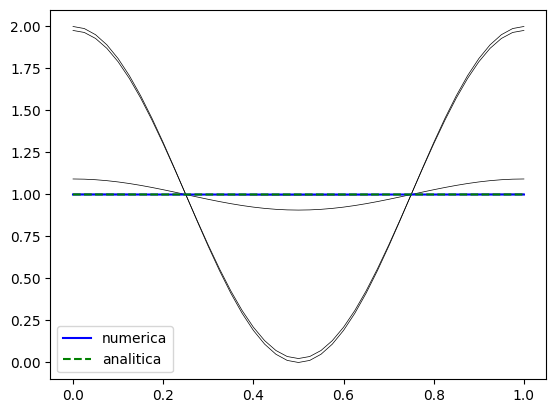

In [5]:
# Domain parameters
t_0 = 0
T = 1
N = 1000
x_0 = 0
x_M = 1
M = 40

# Diffusion coefficient
k = 0.3

# Initial condition
# Create x axis
x = np.linspace(x_0, x_M, M + 1)
# Create u0
u0 = exact_u_cos(0, x, k) + 1

# Add noise to initial condition
scale = 0.05
average = 0
epsilon = np.random.normal(average, scale, len(u0))
# u0 += epsilon

# Solve
u = solve_diffusion(
    t_0,
    T,
    N,
    x_0,
    x_M,
    M,
    k,
    u0,
    diffusion_step_ftcs_neumann,
    0,
    None,
)

delta_t, delta_x, mu = calculate_parameters(t_0, T, N, x_0, x_M, M)

# Animate
animate_u(N, T, x, u, 48, "ex4")

# Plot
plt.plot(x, u[0, :], color="k", linewidth=0.5)
plt.plot(x, u[2, :], color="k", linewidth=0.5)
plt.plot(x, u[int(N / 5), :], color="k", linewidth=0.5)
plt.plot(x, u[int(N / 2), :], color="k", linewidth=0.5)
plt.plot(x, u[-1, :], color="b", label="numerica")
plt.plot(
    x,
    exact_u_cos(T, x, k) + 1,
    color="g",
    linestyle="--",
    label="analitica",
)
plt.title("")
plt.legend()
plt.show()

### Du Fort-Frankel

$$
u_t = k u_{xx} \\
$$

Substituindo no esquema $u^n_m$ por $g ^n e^{im\theta}$, obtemos um resultado para o fator de amplificação equivalente à analise de Von Neumann por transformada de fourier do método:

$$
g^2(1+2k\mu) + g(-4k\mu \cos{\theta}) - (1-2k\mu) = 0 \\
g_\pm = \frac{2k\mu \cos \theta \pm \sqrt{1-4k^2\mu^2 \sin^2\theta}}{1+2k\mu}
$$

Se a quantidade dentro da raiz for positiva,

$$
|g_\pm| = \left | \frac{2k\mu \cos \theta \pm \sqrt{1-4k^2\mu^2 \sin^2\theta}}{1+2k\mu} \right | \le \\
\frac{\left | 2k\mu \right | |\cos \theta| + \left |\sqrt{1-4k^2\mu^2 \sin^2\theta}\right |}{|1+2k\mu|} = \\
\frac{2k\mu   + \left |\sqrt{1-4k^2\mu^2 \sin^2\theta}\right |}{1+2k\mu} <= \\
\frac{2k\mu   + 1}{1+2k\mu} = 1
$$

e então o método é estável. Se a quantidade na raiz for negativa,

$$
|g_\pm|^2 = \frac{(2k\mu\cos\theta)^2 + 4 k^2 \mu^2 \sin^2\theta-1}{(1+2k\mu)^2} = \\
\frac{4 k^2\mu^2-1}{(1+2k\mu)} = \frac{(2k\mu-1)(2k\mu+1)}{(1+2k\mu)^2} = \frac{2k\mu-1}{2k\mu+1} < 1
$$

Portanto, o método é incondicionalmente estável, apesar de ser explícito.

#### Ex. 5 - Conservação da massa

Também pode-se notar que quando $\xi = 0$, $g_\pm = \frac{2k\mu \pm 1}{2k\mu +1}$, e é possível verificar que o método conserva massa no exemplo abaixo (ver `ex5.gif`):


Saving fig 0260 ...  28%
Saving fig 0520 ...  54%
Saving fig 0780 ...  80%
Saving fig 1000 ... 100%


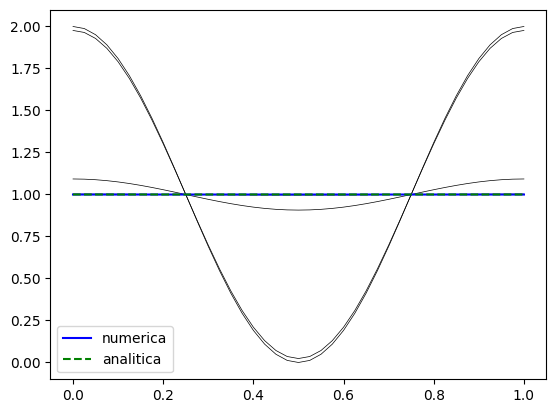

In [6]:
# Domain parameters
t_0 = 0
T = 1
N = 1000
x_0 = 0
x_M = 1
M = 40

# Diffusion coefficient
k = 0.3

# Initial condition
# Create x axis
x = np.linspace(x_0, x_M, M + 1)
# Create u0
u0 = exact_u_cos(0, x, k) + 1

# Add noise to initial condition
scale = 0.05
average = 0
epsilon = np.random.normal(average, scale, len(u0))
# u0 += epsilon

# Solve
u = solve_diffusion(
    t_0,
    T,
    N,
    x_0,
    x_M,
    M,
    k,
    u0,
    diffusion_step_dufort_neumann,
    1,
    diffusion_step_ftcs_neumann,
)

delta_t, delta_x, mu = calculate_parameters(t_0, T, N, x_0, x_M, M)

# Animate
animate_u(N, T, x, u, 48, "ex5")

# Plot
plt.plot(x, u[0, :], color="k", linewidth=0.5)
plt.plot(x, u[2, :], color="k", linewidth=0.5)
plt.plot(x, u[int(N / 5), :], color="k", linewidth=0.5)
plt.plot(x, u[int(N / 2), :], color="k", linewidth=0.5)
plt.plot(x, u[-1, :], color="b", label="numerica")
plt.plot(
    x,
    exact_u_cos(T, x, k) + 1,
    color="g",
    linestyle="--",
    label="analitica",
)
plt.title("")
plt.legend()
plt.show()

### Crank-Nicolson

Substituindo no esquema $u^n_m$ por $g ^n e^{im\theta}$, para cada valor de $n$ e $m$, obtemos um resultado para o fator de amplificação equivalente à analise de Von Neumann do método por transformada de fourier:

$$
g = \frac{1 - 2k\mu \sin^2\frac{\theta}{2}}{1 + 2k\mu \sin^2\frac{\theta}{2}}
$$

Esse fator de amplificação tem sempre módulo menor que 1, portanto o método é incondicionalmente estável.

#### Ex. 6 - Conservação da massa

Para $\xi = 0$, $g = 1$, portanto esse método também conserva massa, como pode ser visto no exemplo abaixo (ver `ex6.gif`), apesar de a solução numérica ter um erro maior com relação à média exata com relação ao FTCS e Du Fort-Frankel:


Saving fig 0260 ...  28%
Saving fig 0520 ...  54%
Saving fig 0780 ...  80%
Saving fig 1000 ... 100%


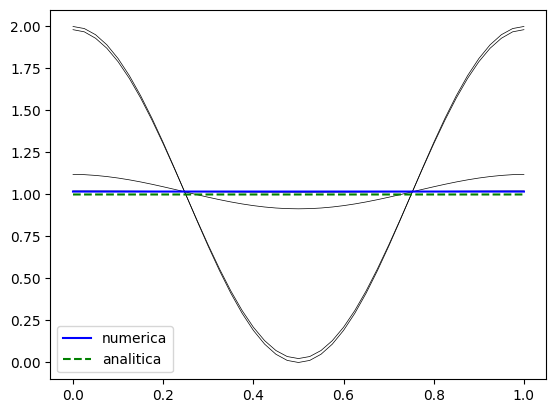

In [7]:
# Domain parameters
t_0 = 0
T = 1
N = 1000
x_0 = 0
x_M = 1
M = 40

# Diffusion coefficient
k = 0.3

# Initial condition
# Create x axis
x = np.linspace(x_0, x_M, M + 1)
# Create u0
u0 = exact_u_cos(0, x, k) + 1

# Add noise to initial condition
scale = 0.05
average = 0
epsilon = np.random.normal(average, scale, len(u0))
# u0 += epsilon

# Solve
u = solve_diffusion(
    t_0,
    T,
    N,
    x_0,
    x_M,
    M,
    k,
    u0,
    diffusion_step_crank_nicolson_neumann,
    0,
    None,
)

delta_t, delta_x, mu = calculate_parameters(t_0, T, N, x_0, x_M, M)

# Animate
animate_u(N, T, x, u, 48, "ex6")

# Plot
plt.plot(x, u[0, :], color="k", linewidth=0.5)
plt.plot(x, u[2, :], color="k", linewidth=0.5)
plt.plot(x, u[int(N / 5), :], color="k", linewidth=0.5)
plt.plot(x, u[int(N / 2), :], color="k", linewidth=0.5)
plt.plot(x, u[-1, :], color="b", label="numerica")
plt.plot(
    x,
    exact_u_cos(T, x, k) + 1,
    color="g",
    linestyle="--",
    label="analitica",
)
plt.title("")
plt.legend()
plt.show()

## Convergência


In [8]:
def run_experiment(
    u0: np.ndarray,
    t_0,
    T,
    N: int,
    x_0,
    x_M,
    M: int,
    k,
    step: Callable,
    num_preprocess_steps: int,
    preprocess_step: Callable = None,
):

    delta_t, delta_x, mu = calculate_parameters(t_0, T, N, x_0, x_M, M)

    # Initial condition
    # Create x axis
    x = np.linspace(x_0, x_M, M + 1)
    # Create u0
    # u0 = exact_u_cos(0, x, k)

    # Add noise to initial condition
    scale = 0.05
    average = 0
    epsilon = np.random.normal(average, scale, len(u0))
    # u0 += epsilon

    # Solve
    u = solve_diffusion(
        t_0,
        T,
        N,
        x_0,
        x_M,
        M,
        k,
        u0,
        step,
        num_preprocess_steps,
        preprocess_step,
    )

    error = L2_norm(u[-1, :] - exact_u_cos(T, x, k), delta_x)

    return u, error

### FTCS


#### $\Delta t$ fixo


In [9]:
errors = []
dts = []
dxs = []
kmus = []

# Domain parameters
t_0 = 0
T = 1
x_0 = 0
x_M = 1
N = 1000
k = 0.3


for M in [2, 4, 8, 16, 32, 34, 36, 38, 40]:

    # Initial condition
    # Create x axis
    x = np.linspace(x_0, x_M, M + 1)
    # Create u0
    u0 = exact_u_cos(0, x, k)

    u, error = run_experiment(
        u0, t_0, T, N, x_0, x_M, M, k, diffusion_step_ftcs_dirichlet, 0, None
    )

    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    errors.append(error)
    dts.append(delta_t)
    dxs.append(delta_x)
    kmus.append(k * mu)

df = create_table([dts, dxs, kmus, errors], ["dt", "dx", "k*mu", "Error [L2 norm]"])
df = create_ratio_column(df)
print(df)

      dt        dx    k*mu  Error [L2 norm] Error ratio
0  0.001  0.500000  0.0012         0.047582            
1  0.001  0.250000  0.0048         0.005133    0.107869
2  0.001  0.125000  0.0192         0.000994    0.193656
3  0.001  0.062500  0.0768         0.000146    0.146654
4  0.001  0.031250  0.3072         0.000056    0.385305
5  0.001  0.029412  0.3468         0.000064     1.13547
6  0.001  0.027778  0.3888         0.000070    1.099912
7  0.001  0.026316  0.4332         0.000076     1.07683
8  0.001  0.025000  0.4800         0.000080    1.060887


É possível notar que para esse método, com $\Delta t$ fixo em um valor pequeno, ao diminuir $\Delta x$ pela metade, o erro cai em aproximadamente 4 vezes (um pouco mais, inclusive), como é de se esperar pela análise da consistência. Também é possível notar que conforme $k\mu$ chega perto de $\frac{1}{2}$, o erro volta a aumentar, pois o método só é estável para valores de $k\mu$ menores que $\frac{1}{2}$.

Note que a partir do experimento 4, os valores de M não aumentam mais duas vezes de uma linha para a outra, por isso os valores da coluna última coluna, da razão do erro, não têm o mesmo significado que para os experimentos de 0 a 3.

Veja no exemplo abaixo o método apresentando instabilidade devido a um valor de $k\mu$ maior que $\frac{1}{2}$:


In [10]:
errors = []
dts = []
dxs = []
kmus = []

# Domain parameters
t_0 = 0
T = 1
x_0 = 0
x_M = 1
N = 1000
M = 45
k = 0.3

# Initial condition
# Create x axis
x = np.linspace(x_0, x_M, M + 1)
# Create u0
u0 = exact_u_cos(0, x, k)

u, error = run_experiment(
    u0, t_0, T, N, x_0, x_M, M, k, diffusion_step_ftcs_dirichlet, 0, None
)

delta_t = (T - t_0) / N
delta_x = (x_M - x_0) / M
mu = delta_t / delta_x**2

errors.append(error)
dts.append(delta_t)
dxs.append(delta_x)
kmus.append(k * mu)

df = create_table([dts, dxs, kmus, errors], ["dt", "dx", "k*mu", "Error [L2 norm]"])
print(df)

      dt        dx    k*mu  Error [L2 norm]
0  0.001  0.022222  0.6075    2.495472e+144


### Du Fort-Frankel


#### $\Delta t$ fixo (pequeno) e $\Delta x$ variando


In [11]:
errors = []
dts = []
dxs = []
dt2_over_dx2s = []

# Domain parameters
t_0 = 0
T = 1
x_0 = 0
x_M = 1
N = 1000
Ms = np.array([5, 10, 20, 40, 80, 160, 320, 640])
k = 0.3

for M in Ms:

    # Initial condition
    # Create x axis
    x = np.linspace(x_0, x_M, M + 1)
    # Create u0
    u0 = exact_u_cos(0, x, k)

    u, error = run_experiment(
        u0,
        t_0,
        T,
        N,
        x_0,
        x_M,
        M,
        k,
        diffusion_step_dufort_dirichlet,
        1,
        diffusion_step_crank_nicolson_dirichlet,
    )

    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2
    dt2_over_dx2 = delta_t**2 / delta_x**2

    errors.append(error)
    dts.append(delta_t)
    dxs.append(delta_x)
    dt2_over_dx2s.append(dt2_over_dx2)

df = create_table(
    [dts, dxs, dt2_over_dx2s, errors], ["dt", "dx", "(dt/dx)^2", "Error [L2 norm]"]
)
df = create_ratio_column(df)
print(df)

      dt        dx  (dt/dx)^2  Error [L2 norm] Error ratio
0  0.001  0.200000   0.000025         0.003119            
1  0.001  0.100000   0.000100         0.000697    0.223597
2  0.001  0.050000   0.000400         0.000143    0.204685
3  0.001  0.025000   0.001600         0.000074    0.519513
4  0.001  0.012500   0.006400         0.000456    6.152534
5  0.001  0.006250   0.025600         0.001845    4.043392
6  0.001  0.003125   0.102400         0.007002    3.795055
7  0.001  0.001563   0.409600         0.021470    3.066155


É possível notar pelos experimentos acima que o erro primeiramente decai com segunda ordem, porém já que a ordem de consistência do método possui um termo $O(\frac{\Delta t^2}{\Delta x^2})$, o erro começa a aumentar conforme $\frac{\Delta t^2}{\Delta x^2}$ aumenta. Portanto, para o esquema ter convergência de segunda ordem, é preciso que $\frac{\Delta t^2}{\Delta x^2}$ aproxime-se de zero com segunda ordem, ou seja, $\frac{\Delta t}{\Delta x^2} = \mu$ seja constante, como exemplificado abaixo:


#### $\Delta t \propto \Delta x^2$


In [12]:
errors = []
dts = []
dxs = []
mus = []

# Domain parameters
t_0 = 0
T = 1
x_0 = 0
x_M = 1
Ns = np.array([5, 10, 20, 40, 80, 160, 320, 640]) ** 2
Ms = np.array([5, 10, 20, 40, 80, 160, 320, 640])
k = 0.3

for N, M in zip(Ns, Ms):
    # Initial condition
    # Create x axis
    x = np.linspace(x_0, x_M, M + 1)
    # Create u0
    u0 = exact_u_cos(0, x, k)

    u, error = run_experiment(
        u0,
        t_0,
        T,
        N,
        x_0,
        x_M,
        M,
        k,
        diffusion_step_dufort_dirichlet,
        1,
        diffusion_step_crank_nicolson_dirichlet,
    )

    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2

    errors.append(error)
    dts.append(delta_t)
    dxs.append(delta_x)
    mus.append(mu)

df = create_table([dts, dxs, mus, errors], ["dt", "dx", "mu", "Error [L2 norm]"])
df = create_ratio_column(df)
print(df)

         dt        dx   mu  Error [L2 norm] Error ratio
0  0.040000  0.200000  1.0     9.333609e-04            
1  0.010000  0.100000  1.0     2.899510e-05    0.031065
2  0.002500  0.050000  1.0     8.199400e-06    0.282786
3  0.000625  0.025000  1.0     3.064400e-06    0.373735
4  0.000156  0.012500  1.0     8.303000e-07     0.27095
5  0.000039  0.006250  1.0     2.116000e-07    0.254848
6  0.000010  0.003125  1.0     5.320000e-08    0.251418
7  0.000002  0.001563  1.0     1.330000e-08        0.25


#### $\Delta t^2 \propto \Delta x^3$


In [13]:
errors = []
dts = []
dxs = []
nus = []

# Domain parameters
t_0 = 0
T = 1
x_0 = 0
x_M = 1
Ns = np.array([2, 4, 8, 16, 32, 64]) ** 3
Ms = np.array([2, 4, 8, 16, 32, 64]) ** 2
k = 0.3

for N, M in zip(Ns, Ms):
    # Initial condition
    # Create x axis
    x = np.linspace(x_0, x_M, M + 1)
    # Create u0
    u0 = exact_u_cos(0, x, k)

    u, error = run_experiment(
        u0,
        t_0,
        T,
        N,
        x_0,
        x_M,
        M,
        k,
        diffusion_step_dufort_dirichlet,
        1,
        diffusion_step_crank_nicolson_dirichlet,
    )

    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    nu = delta_t**2 / delta_x**3

    errors.append(error)
    dts.append(delta_t)
    dxs.append(delta_x)
    nus.append(nu)

df = create_table(
    [dts, dxs, nus, errors], ["dt", "dx", "dt^2 / dx^3", "Error [L2 norm]"]
)
df = create_ratio_column(df, ratio_column_name="dx ratio", raw_column_name="dx")
df = create_ratio_column(df)
print(df)

         dt        dx  dt^2 / dx^3  Error [L2 norm] dx ratio Error ratio
0  0.125000  0.250000          1.0         0.006525                     
1  0.015625  0.062500          1.0         0.003827     0.25    0.586486
2  0.001953  0.015625          1.0         0.001112     0.25    0.290653
3  0.000244  0.003906          1.0         0.000285     0.25    0.256673
4  0.000031  0.000977          1.0         0.000072     0.25    0.251349
5  0.000004  0.000244          1.0         0.000018     0.25    0.250303


Pelo experimento acima, podemos observar que mesmo com condições mais relaxadas para a relação entre $\Delta t$ e $\Delta x$, no caso, $\Delta t^2 \propto \Delta x^3$, o método ainda converge, pois basta que $\frac{\Delta t}{\Delta x} \xrightarrow[\Delta x \to 0]{\Delta t \to 0} 0$ para o esquema ser convergente. Nesse caso, ao multiplicar $\Delta x$ por $\frac{1}{4}$, o erro cai em $4$ vezes, portanto o método converge com ordem $1$, como é de se esperar, pois o método tem ordem de convergência $O(\frac{\Delta t^2}{\Delta x^2}) + O(\Delta t^2) + O(\Delta x^2)$, então quando $\Delta t^2 \propto \Delta x^3$, a ordem de convergência se torna

$$
O(\frac{\Delta x^3}{\Delta x^2}) + O(\Delta x^3) + O(\Delta x^2) = O(\Delta x)
$$


### Crank-Nicolson


#### $\Delta t \propto \Delta x$


In [14]:
errors = []
dts = []
dxs = []
mus = []
lams = []

# Domain parameters
t_0 = 0
T = 1
x_0 = 0
x_M = 1
Ns = np.array([2, 4, 8, 16, 32, 64])
Ms = np.array([2, 4, 8, 16, 32, 64])
k = 0.3

for N, M in zip(Ns, Ms):
    # Initial condition
    # Create x axis
    x = np.linspace(x_0, x_M, M + 1)
    # Create u0
    u0 = exact_u_cos(0, x, k)

    u, error = run_experiment(
        u0,
        t_0,
        T,
        N,
        x_0,
        x_M,
        M,
        k,
        diffusion_step_crank_nicolson_dirichlet,
        0,
        None,
    )

    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2
    lam = delta_t / delta_x

    errors.append(error)
    dts.append(delta_t)
    dxs.append(delta_x)
    mus.append(mu)
    lams.append(lam)

df = create_table(
    [dts, dxs, lams, mus, errors], ["dt", "dx", "lambda", "mu", "Error [L2 norm]"]
)
df = create_ratio_column(df)
print(df)

         dt        dx  lambda    mu  Error [L2 norm] Error ratio
0  0.500000  0.500000     1.0   2.0         0.022993            
1  0.250000  0.250000     1.0   4.0         0.010251    0.445853
2  0.125000  0.125000     1.0   8.0         0.002677    0.261187
3  0.062500  0.062500     1.0  16.0         0.000677    0.252872
4  0.031250  0.031250     1.0  32.0         0.000170    0.250704
5  0.015625  0.015625     1.0  64.0         0.000042    0.250175


Como era de se esperar pela análise da consistência do método, os resultados acima mostram que a ordem de convergência é 2.


### Comparação entre Crank-Nicolson (CN) e FTCS para condição inicial não suave

Como o método Crank-Nicolson (CN) não é dissipativo para $\lambda$ constante, ele pode levar mais tempo para convergir quando comparado ao método FTCS, que é dissipativo, apesar de a ordem de consistência do método Crank-Nicolson ser 2, a ordem de consistência do método FTCS é (1,2).

Para a condição inicial não ser uma onda suave como o cosseno, é adicionado um ruído com média zero, o que não deve alterar a solução final, porém irá ter um efeito mais duradouro em métodos não dissipativos.


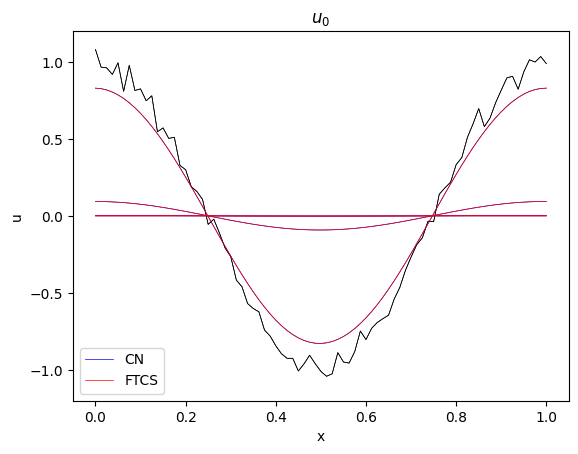

        dt      dx  Error FTCS [L2 norm]  Error CN [L2 norm]  \
0  0.00400  0.2000              0.003674            0.004229   
1  0.00200  0.1000              0.001061            0.001327   
2  0.00100  0.0500              0.000514            0.000641   
3  0.00050  0.0250              0.000257            0.000321   
4  0.00025  0.0125              0.000160            0.000129   

  Error ratio (FTCS) Error ratio (CN)  
0                                      
1           0.288626         0.313884  
2           0.485117         0.482603  
3           0.500436         0.500559  
4           0.620624         0.401274  


In [15]:
errors_cn = []
errors_ftcs = []
dts = []
dxs = []
mus = []
lams = []

# Domain parameters
t_0 = 0
T = 1
x_0 = 0
x_M = 1
Ns = np.array([5, 10, 20, 40, 80]) * 50
Ms = np.array([5, 10, 20, 40, 80])
k = 0.3


for N, M in zip(Ns, Ms):
    # Initial condition
    # Create x axis
    x = np.linspace(x_0, x_M, M + 1)
    # Create u0
    u0 = exact_u_cos(0, x, k)
    # Add noise to initial condition
    scale = 0.05
    average = 0
    np.random.seed(1)
    epsilon = np.random.normal(average, scale, len(u0))
    u0 += epsilon

    u_cn, error_cn = run_experiment(
        u0,
        t_0,
        T,
        N,
        x_0,
        x_M,
        M,
        k,
        diffusion_step_crank_nicolson_dirichlet,
        0,
        None,
    )

    u_ftcs, error_ftcs = run_experiment(
        u0,
        t_0,
        T,
        N,
        x_0,
        x_M,
        M,
        k,
        diffusion_step_ftcs_dirichlet,
        0,
        None,
    )

    delta_t = (T - t_0) / N
    delta_x = (x_M - x_0) / M
    mu = delta_t / delta_x**2
    lam = delta_t / delta_x

    errors_cn.append(error_cn)
    errors_ftcs.append(error_ftcs)
    dts.append(delta_t)
    dxs.append(delta_x)
    mus.append(mu)
    lams.append(lam)

plt.ylabel("u")
plt.xlabel("x")
plt.ylim(-1.2, 1.2)
plt.plot(x, u_cn[0, :], color="k", linewidth=0.5)
plt.plot(x, u_cn[int(np.sqrt(N)), :], color="b", linewidth=0.5, label="CN")
plt.plot(x, u_cn[int(N / 5), :], color="b", linewidth=0.5)
plt.plot(x, u_cn[int(N / 2), :], color="b", linewidth=0.5)
plt.plot(x, u_cn[-1, :], color="b", linewidth=0.5)
plt.plot(x, u_ftcs[0, :], color="k", linewidth=0.5)
plt.plot(x, u_ftcs[int(np.sqrt(N)), :], color="r", linewidth=0.5, label="FTCS")
plt.plot(x, u_ftcs[int(N / 5), :], color="r", linewidth=0.5)
plt.plot(x, u_ftcs[int(N / 2), :], color="r", linewidth=0.5)
plt.plot(x, u_ftcs[-1, :], color="r", linewidth=0.5)
plt.title(r"$u_0$")
plt.legend()
plt.show()

df = create_table(
    [dts, dxs, errors_ftcs, errors_cn],
    ["dt", "dx", "Error FTCS [L2 norm]", "Error CN [L2 norm]"],
)
df = create_ratio_column(
    df, ratio_column_name="Error ratio (FTCS)", raw_column_name="Error FTCS [L2 norm]"
)
df = create_ratio_column(
    df, ratio_column_name="Error ratio (CN)", raw_column_name="Error CN [L2 norm]"
)
print(df)

Pelos resultados acima, é possível ver que, inicialmente, o erro do método FTCS cai mais rapidamente que o erro do método Crank-Nicolson (CN), porém a partir do terceiro experimento, o erro de ambos os métodos cai pela metade (ver colunas `Error ratio (FTCS)` e `Error ratio (CN)` da linha de número 2), e no último experimento, o erro do método Crank-Nicolson fica menor que o erro do método FTCS (ver colunas `Error FTCS [L2 norm]` e `Error CN [L2 norm]`).
